# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] =  14

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Господинов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ L(w_0,w_1,\dots) = -\frac{1}{N}\sum_i \log(\sigma(y^{(i)} g(x^{(i)})) + \frac{1}{C}\sum_jw_j^2 =\\= \frac{1}{N}\sum_i \log(1+e^{-y^{(i)} \sum\limits_j w_j x_j^{(i)} }) + \frac{1}{C}\sum_jw_j^2 \\ \frac{\partial L}{\partial w_k} = -\frac{1}{N} \sum_i \frac{e^{-y^{(i)} \sum\limits_j w_j x_j^{(i)}} y^{(i)} \sum\limits_j \frac{\partial w_j}{\partial w_k} x_j^{(i)}}{1 + e^{-y^{(i)} \sum\limits_j w_j x_j^{(i)} }} + \frac{1}{C}\sum_j 2 w_j \frac{\partial w_j}{\partial w_k} = \\ = -\frac{1}{N} \sum_i \frac{y^{(i)} \sum\limits_j \delta_{jk} x_j^{(i)}}{e^{y^{(i)} \sum\limits_j w_j x_j^{(i)}} + 1} + \frac{1}{C}\sum_j 2 w_j \delta_{jk} = -\frac{1}{N} \sum_i \frac{y^{(i)} x_k^{(i)}} {e^{y^{(i)} \sum\limits_j w_j x_j^{(i)}} + 1} + \frac{2w_k}{C} = -\frac{1}{N} \sum_i y^{(i)} x_k^{(i)}\sigma(-y^{(i)} g(x^{(i)})) + \frac{2w_k}{C}$$

Здесь $k$ определяет индекс столбца матрицы $X$

## Имплементация (5 баллов)

In [5]:
%%pycodestyle


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_count=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_count = batch_count

    def fit(self, X, y):
        '''
        Обучение модели
        '''
        N = y.size

        # добавляем нулевой столбец из единиц для обучения w0
        X_ = np.concatenate((np.ones(N).reshape(-1, 1), X), axis=1)
        self.weights = np.random.rand(X_.shape[1])
        self.costs = np.ones(self.max_epoch)

        # преобразуем классы 0,1 в -1,1
        classes = np.unique(y)
        y_ = np.ones(N)
        y_[y == classes[0]] = -1

        indices = np.arange(N)
        for epoch in range(self.max_epoch):
            # learning rate убывает как 1/n с ростом эпохи
            learning_rate = self.alpha / (epoch + 1)
            # перемешиваем индексы
            np.random.shuffle(indices)
            # бьем на батчи
            bX = np.array_split(X_[indices], self.batch_count)
            by = np.array_split(y_[indices], self.batch_count)
            # для каждого батчка
            for i in range(self.batch_count):
                # вычисляем градиент logloss'а по элементам батча
                grad = -np.sum(
                    (self.sigma(-by[i] * np.sum(self.weights * bX[i], axis=1))
                     * by[i]).reshape(by[i].size, -1) * bX[i], axis=0) / by[i].size + 2 * self.weights / self.C
                # обновляем веса
                self.weights = self.weights - learning_rate * grad
            # для каждой эпохи запоминаем logloss
            self.costs[epoch] = self.logloss(X_, y_)

        return self

    def logloss(self, X, y):
        return - np.sum(
            np.log(self.sigma(y *
                              np.sum(self.weights * X, axis=1)))) / y.size + self.weights.dot(self.weights) / self.C

    @staticmethod
    def sigma(x):
        return 1 / (1 + np.exp(-x))

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''

        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = 1 * (self.predict_proba(X)[0] > 0.5)

        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X_ = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), X), axis=1)
        p_plus = self.sigma(X_.dot(self.weights))
        y_hat_proba = (p_plus, 1 - p_plus)

        return y_hat_proba

53:80: E501 line too long (111 > 79 characters)
64:80: E501 line too long (116 > 79 characters)


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

w_0 = -2.1316096611077477
w_1 = 0.6317114389830709
w_2 = -0.45314662294059604


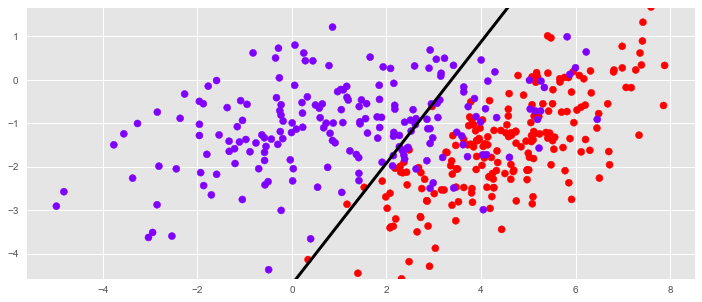

In [6]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y, cmap='rainbow')

model = MySGDClassifier(max_epoch=10, C=1e5, alpha=1)
model.fit(X, y)
W = model.weights

for (i, w) in enumerate(W):
    print('w_{} = {}'.format(i, w))

x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plt.plot(x, -(W[0] + W[1] * x) / W[2], 'k', linewidth=3.0)
plt.ylim(X[:,1].min(), X[:,1].max())
plt.show()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [7]:
from sklearn.datasets import make_classification

In [8]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

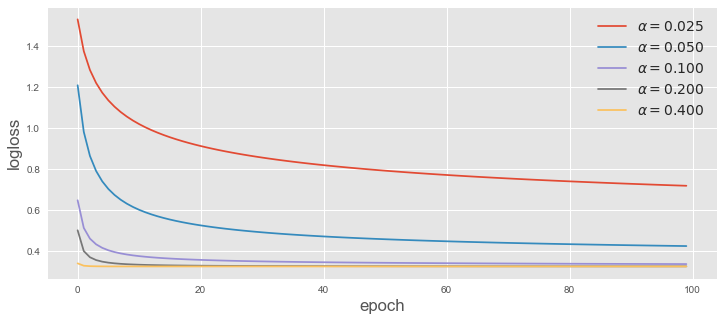

In [9]:
alphas = [0.025, 0.05, 0.1, 0.2, 0.4]
fig, ax = plt.subplots()
for alpha in alphas:
    model = MySGDClassifier(max_epoch=100, C=10, alpha=alpha)
    model.fit(X, y)
    ax.plot(model.costs, label=r'$\alpha=%.3f$' % alpha)
    ax.legend()
    ax.set_ylabel('logloss')
    ax.set_xlabel('epoch')
plt.show()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [10]:
C = np.logspace(3, -3, 10)
N = X.shape[1] + 1
M = C.size

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in exp
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in true_divide


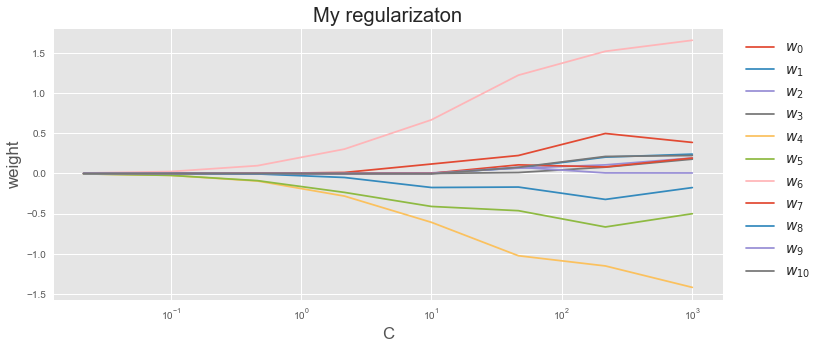

In [11]:
W = np.zeros((M, N))

fig, ax = plt.subplots()

for (i,c) in enumerate(C):
    model = MySGDClassifier(max_epoch=100, C=c, alpha=0.3)
    model.fit(X, y)
    W[i, :] = model.weights
    
for i in range(N):
    ax.semilogx(C, W[:, i], label=r'$w_{%d}$' % i)

ax.legend(bbox_to_anchor=(1.15, 1))
ax.set_ylabel('weight')
ax.set_xlabel('C')
ax.set_title('My regularizaton')
plt.show()

Видно, что при малом $C$ веса стремятся к нулю. Это связано с тем, что $C^{-1}$ становится большим и регуляризующее слагаемое доминирует в функции потерь. Тогда для $L_2$-регуляризации функция потерь приближенно становится параболической с минимумом в нуле. Подобный образом ведет себя и SGDClassifier.

RuntimeWarnings вызваны тем, что для $C < 1$ градиент огромен, SGD начинает расходиться. Компенсировать это можно уменьшением learning rate, но в этом случае не увидим цельной картины для $C > 1$.

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


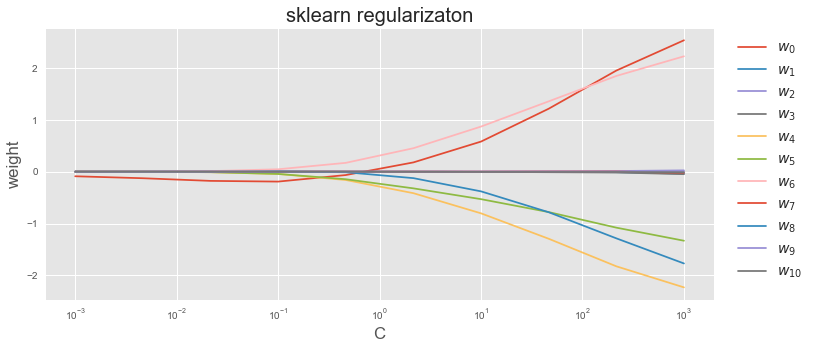

In [12]:
from sklearn.linear_model import SGDClassifier

W = np.zeros((M, N))

fig, ax = plt.subplots()

for (i,c) in enumerate(C):
    model = SGDClassifier(loss='log', penalty='l2', alpha=1/c)
    model.fit(X, y)
    W[i, 0] = model.intercept_
    W[i, 1:] = model.coef_[0]
    
    
for i in range(N):
    ax.semilogx(C, W[:, i], label=r'$w_{%d}$' % i)

ax.legend(bbox_to_anchor=(1.15, 1))
ax.set_ylabel('weight')
ax.set_xlabel('C')
ax.set_title('sklearn regularizaton')
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [13]:
# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [14]:
df_data.shape

(500000, 45)

In [15]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [16]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [17]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [29]:
print('число уникальных карт героя у игрока: %d' % len(df_data['player_hero_card_id'].unique()))
print('число уникальных карт героя у оппонента: %d' % len(df_data['opponent_hero_card_id'].unique()))

def preprocessing(df):
    one_hot_opponent = pd.get_dummies(df['opponent_hero_card_id'], prefix='opponent', drop_first=True)
    one_hot_player = pd.get_dummies(df['player_hero_card_id'], prefix='player', drop_first=True)
    one_hot_data = df.join(one_hot_opponent)
    one_hot_data = one_hot_data.join(one_hot_player)
    return one_hot_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1)

one_hot_data = preprocessing(df_data)
one_hot_data.head().T

число уникальных карт героя у игрока: 9
число уникальных карт героя у оппонента: 9


gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [19]:
y = one_hot_data['decision'].values
X = np.float64(one_hot_data[one_hot_data.columns[1:]].values)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split

model = Pipeline([
    ('sclr', StandardScaler()),
    ('clf', MySGDClassifier()),
])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

C = [10, 100, 250, 500, 1000, 5000, 10000, 50000]
alphas = [0.1, 0.5, 1, 2, 4]
max_epoch = 30
scores = []
params = []

for alpha in alphas:
    for c in C:
        model.set_params(clf__C=c, clf__alpha=alpha, clf__max_epoch=max_epoch)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[0]
        scores.append(roc_auc_score(y_test, y_pred))
        params.append((c, alpha))
        
print('best score: %f' % np.max(scores))
best_params = params[np.argmax(scores)]
model.set_params(clf__C=best_params[0], clf__alpha=best_params[1], clf__max_epoch=max_epoch)
model.fit(X, y)

best score: 0.785061


Pipeline(memory=None,
     steps=[('sclr', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=500, alpha=4, batch_count=10, max_epoch=30))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


ROC-AUC: 0.796311


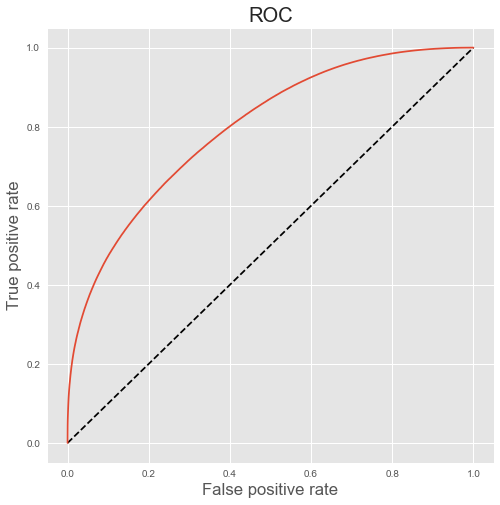

In [23]:
df_list = []
for i in range(5, 8):
    filepath = './testData_tabular_chunk%d.csv' % i
    df_list.append(pd.read_csv(filepath, sep=','))
df_test = pd.concat(df_list)
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')
df_test = df_test.drop(['decision'], axis=1)

y_test = []
with open('./deprecated_testLabels.txt', 'r') as data:
    for val in data.read().split():
        y_test.append(int(val))

y_test = np.array(y_test)
X_test = np.float64(preprocessing(df_test).values)

y_pred = model.predict_proba(X_test)[0]

print('ROC-AUC: %f' % roc_auc_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.plot(fpr, tpr)
plt.show()